In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def correct_incorrect_losses(df):
    losses = df['reconstruction_losses'].values
    correct_indices = (df['predictions'] == df['labels'])
    correctly_classified_losses = losses[correct_indices]
    incorrectly_classified_losses = losses[np.invert(correct_indices)]
    return correctly_classified_losses, incorrectly_classified_losses

In [3]:
def histogram(arr, title=""):
    plt.hist(arr, bins=30)
    plt.title(title)
    plt.show()
    return

def overlapping_histograms(arrs, labels, title=""):
    plt.hist(arrs, label=labels, density=True, bins=30)
    plt.title(title)
    plt.legend()
    plt.show()
    return

mnist test set
      predictions  labels  reconstruction_losses
0               6       6               0.004979
1               2       2               0.007652
2               3       3               0.010006
3               7       7               0.014636
4               2       2               0.012961
...           ...     ...                    ...
9995            3       3               0.022667
9996            4       4               0.016839
9997            2       2               0.020022
9998            6       6               0.010132
9999            1       1               0.001708

[10000 rows x 3 columns]
95th percentile of Correctly Classified Reconstruction Loss: 0.024140937449999955
99.5th percentile of Correctly Classified Reconstruction Loss: 0.03743717462500003


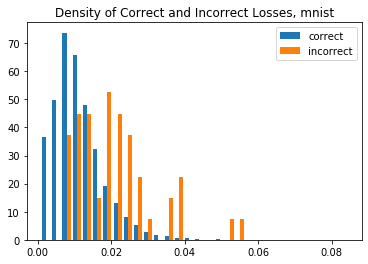

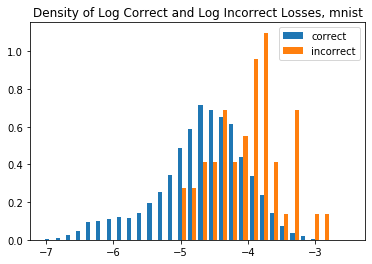

In [114]:
def display_test_set_no_patch_recon_distributions(dataset):
    print(dataset + " test set")
    test = pd.read_csv("./saved_patches/%s/no_patch_recon_losses.csv"%dataset)
    print(test)
    correct_losses, incorrect_losses = correct_incorrect_losses(test)
    critical_95 = np.percentile(correct_losses, 95)
    print("95th percentile of Correctly Classified Reconstruction Loss: " + str(critical_95))
    critical_995 = np.percentile(correct_losses, 99.5)
    print("99.5th percentile of Correctly Classified Reconstruction Loss: " + str(critical_995))
    log_cl, log_icl = np.log(correct_losses), np.log(incorrect_losses)
    overlapping_histograms([correct_losses,incorrect_losses], ["correct", "incorrect"], "Density of Correct and Incorrect Losses, " + dataset)
    overlapping_histograms([log_cl, log_icl], ["correct", "incorrect"], "Density of Log Correct and Log Incorrect Losses, " + dataset)

display_test_set_no_patch_recon_distributions("mnist")

In [119]:
def display_scaled_patch_success_detection_rates(df, target_class:int, det_thres:float):
    def fooled_rate(data):
        # P(fooled)
        fooled = (data['predictions'] == target_class)
        num_fooled = np.count_nonzero(fooled)
        return num_fooled / len(fooled)
    def detection_rate(data):
        # P(detected)
        detected = (data['reconstruction_losses'] > det_thres)
        num_detected = np.count_nonzero(detected)
        return num_detected / len(detected)
    def s_detection_rate(data):
        # P(detected | fooled)
        fooled = (data['predictions'] == target_class)
        detected = (fooled & (data['reconstruction_losses'] > det_thres))
        num_detected = np.count_nonzero(detected)
        num_fooled = np.count_nonzero(fooled)
        if num_fooled > 0:
            return num_detected / num_fooled
        else:
            return None
    def f_detection_rate(data):
        # P(detected | not fooled)
        not_fooled = (data['predictions'] != target_class)
        detected = (not_fooled & (data['reconstruction_losses'] > det_thres))
        num_detected = np.count_nonzero(detected)
        num_not_fooled = np.count_nonzero(not_fooled)
        if num_not_fooled > 0:
            return num_detected / num_not_fooled
        else:
            return None
    filtered = df[df['labels'] != target_class]
    fooled_rates = filtered.groupby('scales').apply(fooled_rate)
    detection_rates = filtered.groupby('scales').apply(detection_rate)
    s_detection_rates = filtered.groupby('scales').apply(s_detection_rate)
    f_detection_rates = filtered.groupby('scales').apply(f_detection_rate)
    scales = fooled_rates.index
    plt.plot(scales, fooled_rates, '-o', label="ASR")
    plt.plot(scales, detection_rates, '-o', label="DPR")
    plt.plot(scales, s_detection_rates, '-o', label="ASPR")
    plt.plot(scales, f_detection_rates, '-o', label="AFPR")
    plt.xlabel("Patch Scale")
    plt.legend(loc='upper left')
    plt.xticks()
    plt.show()
    print("ASR: adversarial success rate")
    print("DPR: detection positive rate")
    print("ASPR: adversarial success positive rate")
    print("AFPR: adversarial failure positive rate")


def display_scaled_recon_distributions(df, target_class:int):
    def plot_distribution(data):
        scale = data.scales.values[0]
        correct_losses, incorrect_losses = correct_incorrect_losses(data)
        #log_cl, log_icl = np.log(correct_losses), np.log(incorrect_losses)
        overlapping_histograms([correct_losses,incorrect_losses], ["correct", "incorrect"], "Density of Correct and Incorrect Losses, Patch Scaled by " + str(scale))
        #overlapping_histograms([log_cl, log_icl], ["correct", "incorrect"], "Density of Log Correct and Log Incorrect Losses, Patch Scaled by " + str(scale))
        return 0
    filtered = df[df['labels'] != target_class]
    filtered.groupby('scales').apply(plot_distribution)

In [111]:
data = pd.read_csv("saved_patches/mnist/train/adv_test.csv")
print(data)

       predictions  labels  reconstruction_losses  scales
0                6       6               0.004979     0.0
1                2       2               0.007652     0.0
2                3       3               0.010006     0.0
3                7       7               0.014636     0.0
4                2       2               0.012961     0.0
...            ...     ...                    ...     ...
99995            0       3               0.060293     0.9
99996            0       4               0.049645     0.9
99997            0       2               0.052796     0.9
99998            0       6               0.048569     0.9
99999            0       1               0.044874     0.9

[100000 rows x 4 columns]


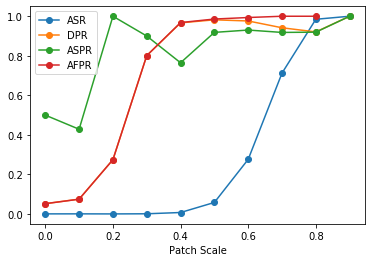

ASR: adversarial success rate
DPR: detection positive rate
ASPR: adversarial success positive rate
AFPR: adversarial failure positive rate


In [120]:
crit_5 = 0.024140937449999955
crit_point_5 = 0.03743717462500003
display_scaled_patch_success_detection_rates(data, target_class=0, det_thres=crit_5)

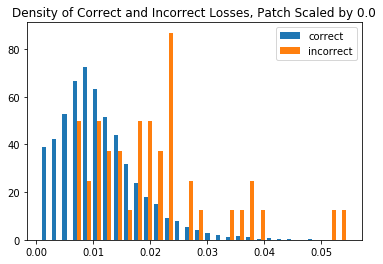

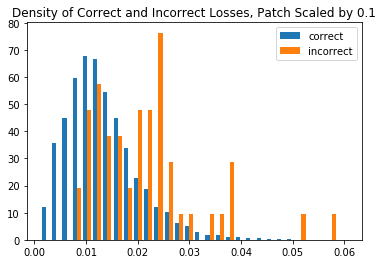

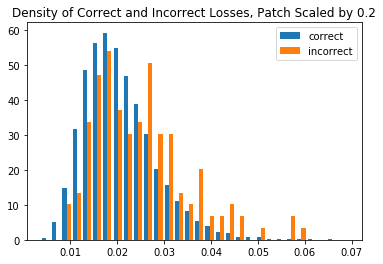

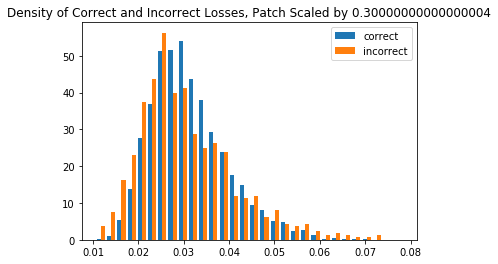

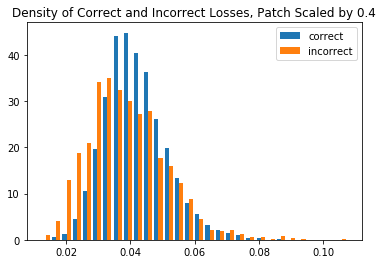

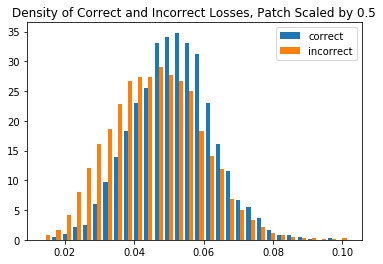

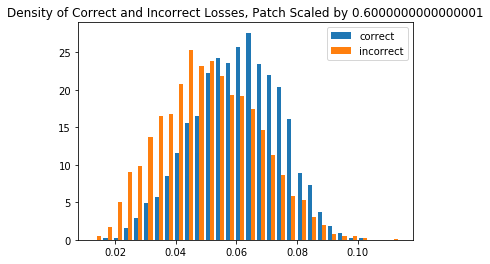

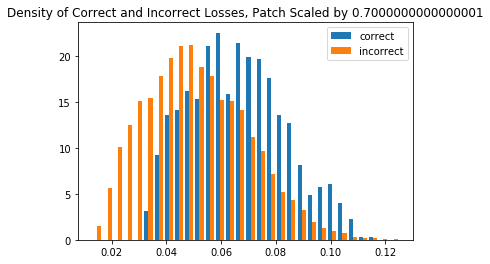

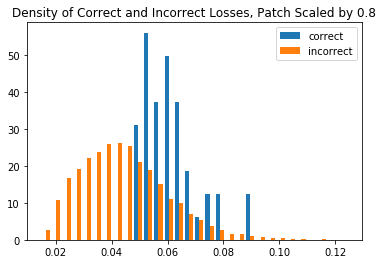

/home/perry/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


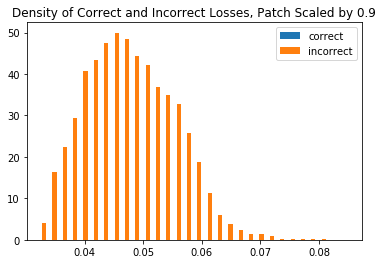

In [112]:
display_scaled_recon_distributions(data, target_class=0)